### Import libraries


In [1]:
import requests
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ssl
import matplotlib.ticker as mticker
from matplotlib.ticker import FuncFormatter

### Fetch data from the API | Census

In [2]:
class TLSAdapter(requests.adapters.HTTPAdapter):
    def init_poolmanager(self, *args, **kwargs):
        ctx = ssl.create_default_context()
        ctx.set_ciphers("DEFAULT@SECLEVEL=1")
        ctx.options |= 0x4   # <-- the key part here, OP_LEGACY_SERVER_CONNECT
        kwargs["ssl_context"] = ctx
        return super(TLSAdapter, self).init_poolmanager(*args, **kwargs)

url_get_1872_2010 = 'https://servicodados.ibge.gov.br/api/v3/agregados/1286/periodos/1872|1890|1900|1920|1940|1950|1960|1970|1980|1991|2000|2010/variaveis/606?localidades=N3[all]'
url_get_2022 = 'https://servicodados.ibge.gov.br/api/v3/agregados/4712/periodos/2022/variaveis/382?localidades=N6[all]'

responses_data = {}

with requests.session() as s:
    s.mount("https://", TLSAdapter())
    
    # Request for the 1872-2010 Period
    response_1872_2010 = s.get(url_get_1872_2010)
    if response_1872_2010.status_code == 200:
        responses_data["1872_2010"] = response_1872_2010.json()
    else:
        print(f"1872-2010 Request Failed with Code {response_1872_2010.status_code}")

    # Request for 2022
    response_2022 = s.get(url_get_2022)
    if response_2022.status_code == 200:
        responses_data["2022"] = response_2022.json()
    else:
        print(f"2022 Request Failed with Code {response_2022.status_code}")

## Extract Data and Convert into a DataFrame | 1872 to 2010

In [3]:
# Extract Data for 1872-2010
data_1872_2010 = responses_data["1872_2010"][0]['resultados'][0]['series']

# Convert Data into a DataFrame
df_1872_2010 = pd.DataFrame(data_1872_2010)

# Extract 'locality' and 'series' Information into Separate Columns
df_1872_2010['State'] = df_1872_2010['localidade'].apply(lambda x: x['nome'])
df_1872_2010 = pd.concat([df_1872_2010.drop(['serie'], axis=1), df_1872_2010['serie'].apply(pd.Series)], axis=1)

# Discard the 'locality' Column as It Is No Longer Needed
df_1872_2010 = df_1872_2010.drop(['localidade'], axis=1)

df_1872_2010.head()

,State,1872,1890,1900,1920,1940,1950,1960,1970,1980,1991,2000,2010
0,Rondônia,-,-,-,-,-,36935,70783,116620,503125,1130874,1377792,1562409
1,Acre,-,-,-,92379,79768,114755,160208,218006,306893,417165,557226,733559
2,Amazonas,57610,147915,249756,363166,438008,514099,721215,960934,1449135,2102901,2813085,3483985
3,Roraima,-,-,-,-,-,18116,29489,41638,82018,215950,324152,450479
4,Pará,275237,328455,445356,983507,944644,1123273,1550935,2197072,3507312,5181570,6189550,7581051


## Mapping states abbreviations

In [4]:
# Map of state names to abbreviations
state_name_to_abbrev = {
    'Rondônia': 'RO', 'Acre': 'AC', 'Amazonas': 'AM', 'Roraima': 'RR',
    'Pará': 'PA', 'Amapá': 'AP', 'Tocantins': 'TO', 'Maranhão': 'MA',
    'Piauí': 'PI', 'Ceará': 'CE', 'Rio Grande do Norte': 'RN', 'Paraíba': 'PB',
    'Pernambuco': 'PE', 'Alagoas': 'AL', 'Sergipe': 'SE', 'Bahia': 'BA',
    'Minas Gerais': 'MG', 'Espírito Santo': 'ES', 'Rio de Janeiro': 'RJ',
    'São Paulo': 'SP', 'Paraná': 'PR', 'Santa Catarina': 'SC', 'Rio Grande do Sul': 'RS',
    'Mato Grosso do Sul': 'MS', 'Mato Grosso': 'MT', 'Goiás': 'GO', 'Distrito Federal': 'DF'
}

# Replace state names with abbreviations
df_1872_2010['State'] = df_1872_2010['State'].replace(state_name_to_abbrev)

# Sort dataframe by state abbreviations
df_1872_2010_sorted = df_1872_2010.sort_values(by='State').reset_index(drop=True)
print(df_1872_2010_sorted)

   State     1872     1890     1900     1920     1940     1950      1960  \
0     AC        -        -        -    92379    79768   114755    160208   
1     AL   348009   511440   649273   978748   951300  1093137   1271062   
2     AM    57610   147915   249756   363166   438008   514099    721215   
3     AP        -        -        -        -        -    37477     68889   
4     BA  1379616  1919802  2117956  3334465  3918112  4834575   5990605   
5     CE   721686   805687   849127  1319228  2091032  2695450   3337856   
6     DF        -        -        -        -        -        -    141742   
7     ES    82137   135997   209783   457328   790149   957238   1418348   
8     GO   160395   227572   255284   511919   661226  1010880   1626376   
9     MA   359040   430854   499308   874337  1235169  1583248   2492139   
10    MG  2039735  3184099  3594471  5888174  6763368  7782188   9960040   
11    MS        -        -        -        -   238640   309395    579652   
12    MT    

## Extract Data and Convert into a DataFrame | 2022

In [5]:
# Extract Data for 2022
data_2022 = responses_data["2022"][0]['resultados'][0]['series']

# Convert Data into a DataFrame
df_2022 = pd.DataFrame(data_2022)

# Extract 'locality' and 'series' Information into Separate Columns
df_2022['State'] = df_2022['localidade'].apply(lambda x: x['nome'])
df_2022 = pd.concat([df_2022.drop(['serie'], axis=1), df_2022['serie'].apply(pd.Series)], axis=1)

# Discard the 'locality' Column as It Is No Longer Needed
df_2022 = df_2022.drop(['localidade'], axis=1)

df_2022.head()

,State,2022
0,Alta Floresta D'Oeste - RO,21440
1,Ariquemes - RO,96152
2,Cabixi - RO,5351
3,Cacoal - RO,86494
4,Cerejeiras - RO,15798


In [6]:
# Extract the State Name from the "State" Column and Create a New Column "Estado"
df_2022['Estado'] = df_2022['State'].str.extract(r'-(\s\w\w)$')[0].str.strip()

# Group by "Estado" and Sum the Population for 2022
df_2022_total = df_2022.groupby('Estado')['2022'].sum().reset_index()

# Convert the "2022" Column to Integers
df_2022["2022"] = df_2022["2022"].astype(int)

# Group by "Estado" and Sum the Population for 2022
df_2022_total_corrected = df_2022.groupby('Estado')['2022'].sum().reset_index()

print(df_2022_total_corrected)

   Estado      2022
0      AC    824448
1      AL   3117345
2      AM   3929369
3      AP    729353
4      BA  14103181
5      CE   8771496
6      DF   2792811
7      ES   3808060
8      GO   7022513
9      MA   6759838
10     MG  20436535
11     MS   2737054
12     MT   3635989
13     PA   8088984
14     PB   3959587
15     PE   9018330
16     PI   3263283
17     PR  11390719
18     RJ  15991284
19     RN   3291201
20     RO   1572676
21     RR    622859
22     RS  10816723
23     SC   7573632
24     SE   2201997
25     SP  44117616
26     TO   1506137


In [7]:
# Merge the dataframes
merged_df = pd.merge(df_1872_2010_sorted, df_2022_total_corrected, left_on='State', right_on='Estado', how='left').drop('Estado', axis=1)
print(merged_df)

   State     1872     1890     1900     1920     1940     1950      1960  \
0     AC        -        -        -    92379    79768   114755    160208   
1     AL   348009   511440   649273   978748   951300  1093137   1271062   
2     AM    57610   147915   249756   363166   438008   514099    721215   
3     AP        -        -        -        -        -    37477     68889   
4     BA  1379616  1919802  2117956  3334465  3918112  4834575   5990605   
5     CE   721686   805687   849127  1319228  2091032  2695450   3337856   
6     DF        -        -        -        -        -        -    141742   
7     ES    82137   135997   209783   457328   790149   957238   1418348   
8     GO   160395   227572   255284   511919   661226  1010880   1626376   
9     MA   359040   430854   499308   874337  1235169  1583248   2492139   
10    MG  2039735  3184099  3594471  5888174  6763368  7782188   9960040   
11    MS        -        -        -        -   238640   309395    579652   
12    MT    

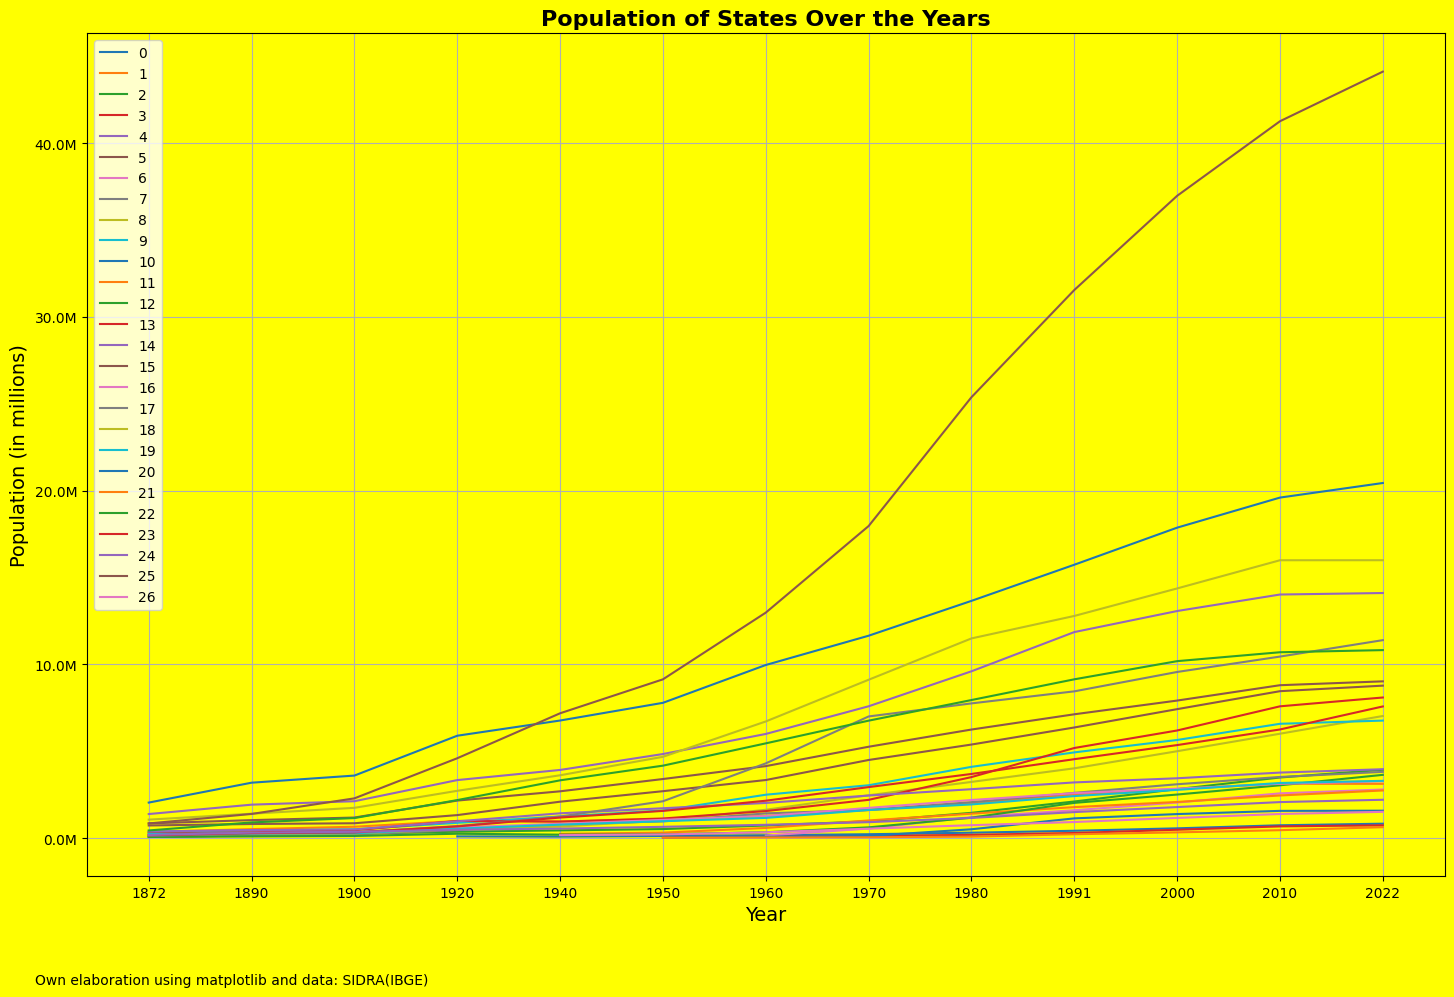

In [8]:
# Substituir '-' por NaN
merged_df.replace('-', np.nan, inplace=True)

# Converter os dados para numérico
merged_df = merged_df.apply(pd.to_numeric, errors='coerce')

# Função para formatar o eixo y
def millions(x, pos):
    return '%1.1fM' % (x * 1e-6)

formatter = FuncFormatter(millions)

# Plotagem
plt.figure(figsize=(15, 10))
ax = plt.gca()
ax.set_facecolor('yellow')
plt.gcf().set_facecolor('yellow')

for state in merged_df.index:
    plt.plot(merged_df.columns, merged_df.loc[state], label=state)

plt.title('Population of States Over the Years', fontsize=16, color='black', fontweight='bold')
plt.xlabel('Year', fontsize=14, color='black')
plt.ylabel('Population (in millions)', fontsize=14, color='black')
ax.yaxis.set_major_formatter(formatter)
plt.legend(loc='upper left')
plt.grid(True)

plt.text(0.05, 0.01, 'Own elaboration using matplotlib and data: SIDRA(IBGE)', transform=plt.gcf().transFigure, horizontalalignment='left')
plt.tight_layout()
plt.show()


In [24]:
cols_to_convert = merged_df.columns[merged_df.columns != 'State']
merged_df[cols_to_convert] = merged_df[cols_to_convert].apply(pd.to_numeric, errors='coerce')

In [34]:
# Calcular os totais diretamente, já que 'State' é um índice e não uma coluna
totals = merged_df.sum()

# Criar totals_df
totals_df = pd.DataFrame({'Year': totals.index, 'Total': totals.values})

# Imprimir totals para verificar
print(totals)


1872      9930478.0
1890     14333915.0
1900     17438434.0
1920     30635605.0
1940     41236315.0
1950     51944397.0
1960     70992343.0
1970     94508583.0
1980    121150573.0
1991    146917459.0
2000    169590693.0
2010    190755799.0
2022    202083020.0
dtype: float64


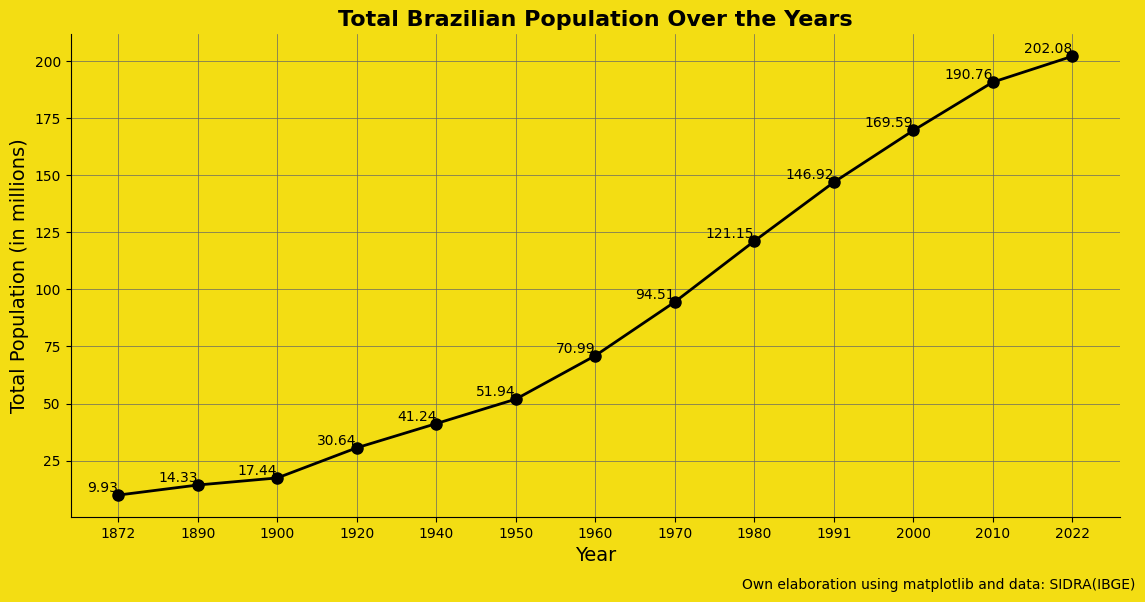

In [36]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(totals.index, totals.values / 1_000_000, marker='o', markersize=8, color='black', linestyle='-', linewidth=2)

# Adicionando rótulos aos pontos
for x, y in zip(totals.index, totals.values / 1_000_000):
    plt.text(x, y, str(round(y, 2)), color='black', fontsize=10, verticalalignment='bottom', horizontalalignment='right')

plt.title('Total Brazilian Population Over the Years', fontsize=16, color='black', fontweight='bold')
plt.xlabel('Year', fontsize=14, color='black')
plt.ylabel('Total Population (in millions)', fontsize=14, color='black')

# Setting background and plot area colors
ax = plt.gca()
ax.set_facecolor('#f3dd13')  # Plot area background color
plt.gcf().set_facecolor('#f3dd13')  # Figure background color

# Adjust the y-axis to not use scientific notation
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

# Hide the right and top spines (secondary axes)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Customize grid lines
ax.grid(True, which='major', color='#666666', linestyle='-', linewidth=0.5)

# Adicionando a nota de rodapé
plt.text(0.95, 0.01, 'Own elaboration using matplotlib and data: SIDRA(IBGE)', transform=plt.gcf().transFigure, horizontalalignment='right')

plt.tight_layout()
plt.show()

posx and posy should be finite values
posx and posy should be finite values


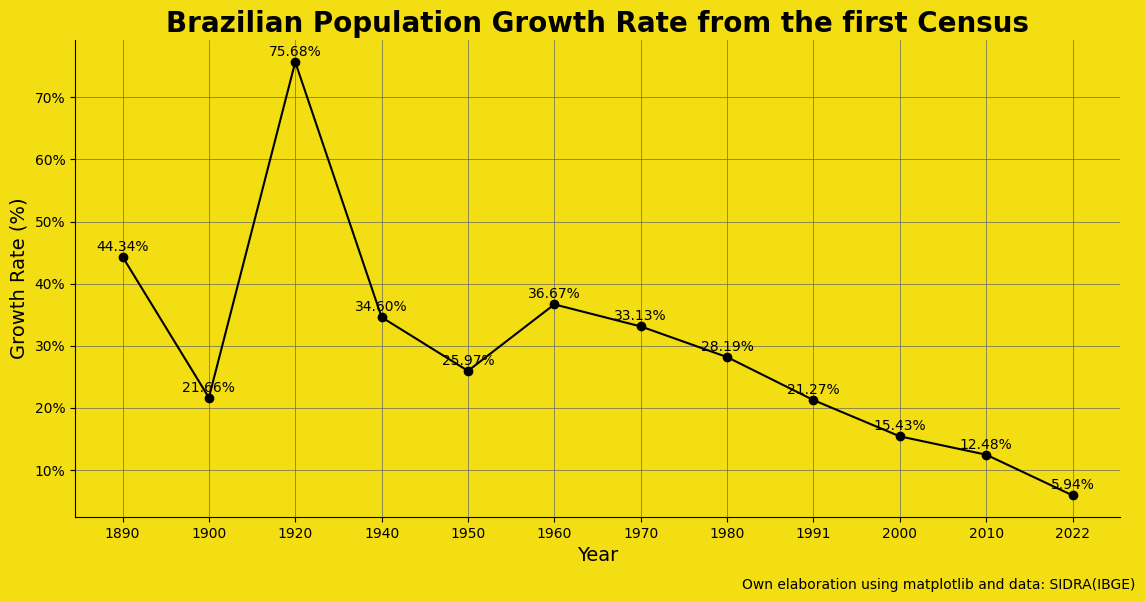

In [37]:
# Calcular a taxa de crescimento anual
growth_rate = ((totals / totals.shift(1)) - 1)

# Plotar o gráfico da taxa de crescimento
plt.figure(figsize=(12, 6))
plt.plot(growth_rate.index, growth_rate.values * 100, marker='o', color='black', linestyle='-')  # Multiplicar por 100 para converter para porcentagem

# Adicionando rótulos aos pontos
for x, y in zip(growth_rate.index, growth_rate.values * 100):
    plt.text(x, y + 0.5, f'{y:.2f}%', color='black', fontsize=10, verticalalignment='bottom', horizontalalignment='center')

plt.title('Brazilian Population Growth Rate from the first Census', fontsize=20, color='black', fontweight='bold')
plt.xlabel('Year', fontsize=14, color='black')
plt.ylabel('Growth Rate (%)', fontsize=14, color='black')

# Definindo as cores de fundo
ax = plt.gca()
ax.set_facecolor('#f3dd13')  # Cor de fundo da área de plotagem
plt.gcf().set_facecolor('#f3dd13')  # Cor de fundo da figura

# Formatando o eixo y para mostrar porcentagens
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: '{:.0f}%'.format(y)))

# Esconder os eixos secundários à direita e acima
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Personalizar as linhas de grade
ax.grid(True, which='major', color='#666666', linestyle='-', linewidth=0.5)

# Adicionando a nota de rodapé
plt.text(0.95, 0.01, 'Own elaboration using matplotlib and data: SIDRA(IBGE)', transform=plt.gcf().transFigure, horizontalalignment='right')

plt.tight_layout()
plt.show()

In [38]:
print(growth_rate)

1872         NaN
1890    0.443426
1900    0.216586
1920    0.756786
1940    0.346026
1950    0.259676
1960    0.366699
1970    0.331250
1980    0.281900
1991    0.212685
2000    0.154326
2010    0.124801
2022    0.059381
dtype: float64


posx and posy should be finite values
posx and posy should be finite values


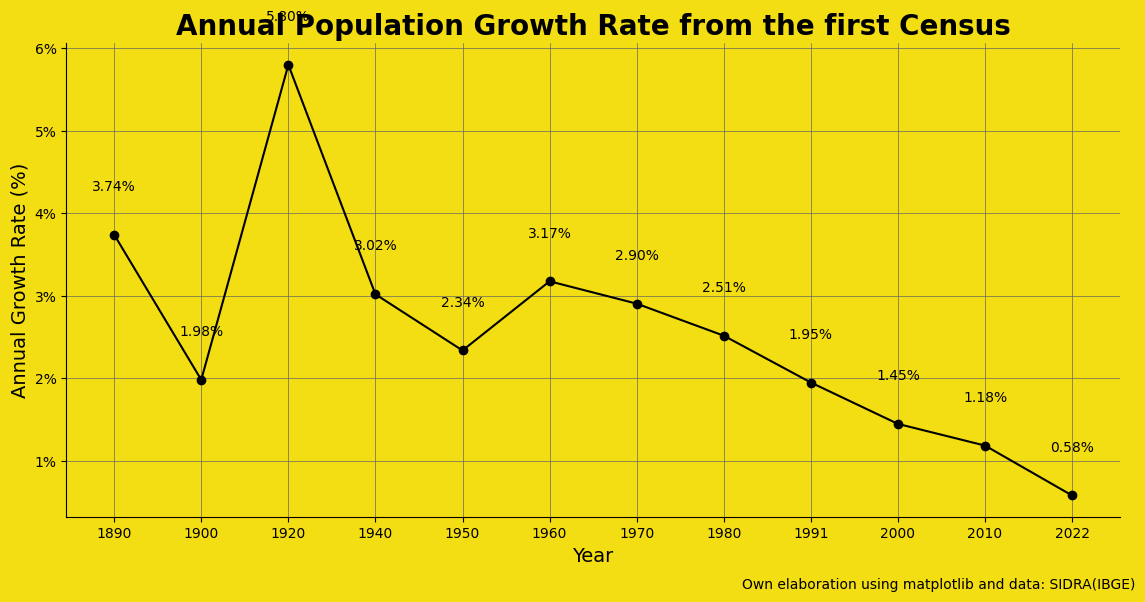

In [40]:
# Calcular a taxa de crescimento anual
growth_rate = ((totals / totals.shift(1)) ** (1/10)) - 1

# Plotar o gráfico da taxa de crescimento
plt.figure(figsize=(12, 6))
plt.plot(growth_rate.index, growth_rate.values * 100, marker='o', color='black', linestyle='-')  # Multiplicar por 100 para converter para porcentagem

# Adicionando rótulos aos pontos
for x, y in zip(growth_rate.index, growth_rate.values * 100):
    plt.text(x, y + 0.5, f'{y:.2f}%', color='black', fontsize=10, verticalalignment='bottom', horizontalalignment='center')

plt.title('Annual Population Growth Rate from the first Census', fontsize=20, color='black', fontweight='bold')
plt.xlabel('Year', fontsize=14, color='black')
plt.ylabel('Annual Growth Rate (%)', fontsize=14, color='black')

# Definindo as cores de fundo
ax = plt.gca()
ax.set_facecolor('#f3dd13')  # Cor de fundo da área de plotagem
plt.gcf().set_facecolor('#f3dd13')  # Cor de fundo da figura

# Formatando o eixo y para mostrar porcentagens
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: '{:.0f}%'.format(y)))

# Esconder os eixos secundários à direita e acima
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Personalizar as linhas de grade
ax.grid(True, which='major', color='#666666', linestyle='-', linewidth=0.5)

# Adicionando a nota de rodapé
plt.text(0.95, 0.01, 'Own elaboration using matplotlib and data: SIDRA(IBGE)', transform=plt.gcf().transFigure, horizontalalignment='right')

plt.tight_layout()
plt.show()


## Finding top 10 Smallest Cities

In [45]:
# Supondo que 'cities_df' seja o seu DataFrame e ele tenha as colunas 'Cidade' e 'População'
# Ordenar o DataFrame pela população em ordem crescente
cities_df_sorted = df_2022.sort_values(by='2022')

# Selecionar as primeiras N linhas para obter as menores cidades
# Por exemplo, para obter as 10 menores cidades
smallest_cities = cities_df_sorted.head(10)

# Exibir as menores cidades
print(smallest_cities)


                                State  2022 Estado
3026            Serra da Saudade - MG   829     MG
3348                        Borá - SP   907     SP
5339                  Anhanguera - GO   924     GO
5192                  Araguainha - MT  1005     MT
3637               Nova Castilho - SP  1062     SP
2415             Cedro do Abaeté - MG  1081     MG
4620              André da Rocha - RS  1135     RS
398           Oliveira de Fátima - TO  1164     TO
5077              União da Serra - RS  1170     RS
3004  São Sebastião do Rio Preto - MG  1259     MG


## Finding TOP 10 Largests Cities

In [46]:
# Sort the DataFrame by '2022' in descending order
cities_df_sorted = df_2022.sort_values(by='2022', ascending=False)

# Get the 10 largest cities
largest_cities = cities_df_sorted.head(10)

# Display the largest cities
print(largest_cities)

                    State      2022 Estado
3829       São Paulo - SP  11395157     SP
3242  Rio de Janeiro - RJ   6174549     RJ
5569        Brasília - DF   2792811     DF
949        Fortaleza - CE   2424880     CE
2162        Salvador - BA   2407866     BA
2309  Belo Horizonte - MG   2306189     MG
111           Manaus - AM   2058504     AM
4005        Curitiba - PR   1766225     PR
1596          Recife - PE   1479517     PE
5417         Goiânia - GO   1434426     GO


In [54]:
# Ordenar as cidades por população no ano de 2022
df_2022_sorted = df_2022.sort_values(by='2022', ascending=False)

# Selecionar a maior cidade, top 3, 5 e 10 cidades
top_1 = df_2022_sorted.head(1)
top_3_cidades = df_2022_sorted.head(3)
top_5_cidades = df_2022_sorted.head(5)
top_10_cidades = df_2022_sorted.head(10)

# Calcular a população dessas cidades em 2022
populacao_top_1 = top_1['2022'].sum()
populacao_top_3 = top_3_cidades['2022'].sum()
populacao_top_5 = top_5_cidades['2022'].sum()
populacao_top_10 = top_10_cidades['2022'].sum()

# Calcular a população total do país em 2022
populacao_total_pais = df_2022['2022'].sum()

# Calcular a população do resto do país
populacao_resto_1 = populacao_total_pais - populacao_top_1
populacao_resto_3 = populacao_total_pais - populacao_top_3
populacao_resto_5 = populacao_total_pais - populacao_top_5
populacao_resto_10 = populacao_total_pais - populacao_top_10


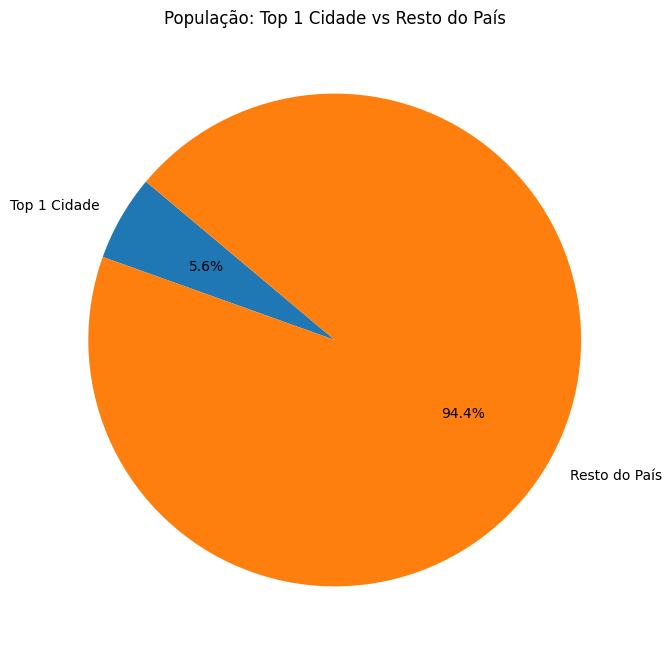

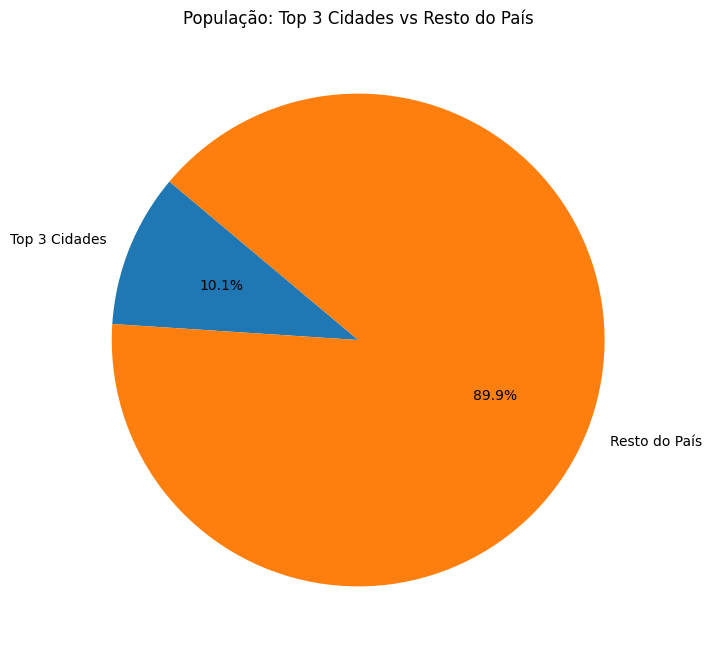

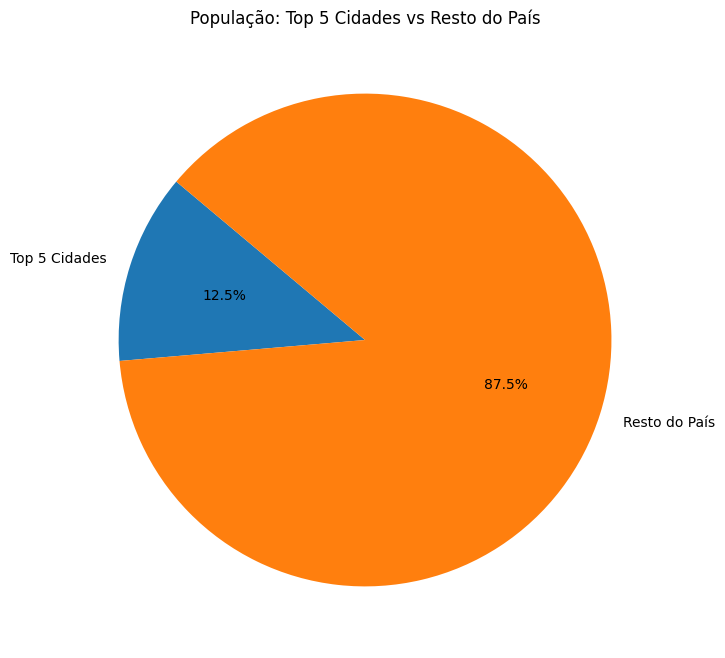

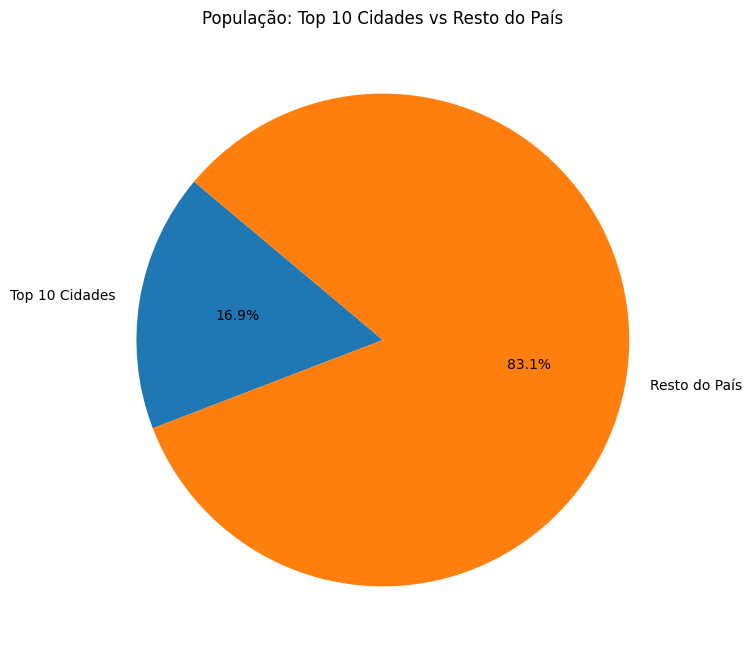

In [55]:
import matplotlib.pyplot as plt

def plot_pie_chart(sizes, labels, title):
    plt.figure(figsize=(8, 8))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.show()

# Gráfico para a maior cidade
plot_pie_chart([populacao_top_1, populacao_resto_1], ['Top 1 Cidade', 'Resto do País'], 'População: Top 1 Cidade vs Resto do País')

# Gráfico para as 3 maiores cidades
plot_pie_chart([populacao_top_3, populacao_resto_3], ['Top 3 Cidades', 'Resto do País'], 'População: Top 3 Cidades vs Resto do País')

# Gráfico para as 5 maiores cidades
plot_pie_chart([populacao_top_5, populacao_resto_5], ['Top 5 Cidades', 'Resto do País'], 'População: Top 5 Cidades vs Resto do País')

# Gráfico para as 10 maiores cidades
plot_pie_chart([populacao_top_10, populacao_resto_10], ['Top 10 Cidades', 'Resto do País'], 'População: Top 10 Cidades vs Resto do País')
